In [1]:
import gpytorch
import linear_operator
from lodegp.LODEGP import LODEGP
import torch
from torch import pi
from matplotlib import pyplot as plt
from time import perf_counter

torch.set_default_dtype(torch.float64)
"""
System: Angular velocity of a permanent magnet synchronous motor
with the motor torque 3/4  * p * Phi * i_q(t) = tau(t)

J_m * omega'(t) + b_m * omega(t) - 3/4 * p * Phi * i_q(t) = 0
"""
sp = {"bm": float(0.05), "Jm": float(0.01), "p": float(8), "Phi": float(0.02)}
COUNT = int(400)
TRAIN_ITERATIONS = int(100)

In [2]:
START = float(0)
END = float(2)
train_x = torch.linspace(START, END, COUNT)
steps_s = COUNT / END

# generate input with missing i_q obs
cosine_interp = lambda x, y0, y1, a, b: y0 + (y1 - y0) * (float(1) - torch.cos(pi * (x-a)/(b-a))) / float(2)
omega = torch.zeros_like(train_x)
ramp = cosine_interp(train_x, float(0), float(100), float(0.1), float(0.9))
omega[int(0.1 * steps_s): int(0.9 * steps_s)] = ramp[int(0.1 * steps_s): int(0.9 * steps_s)]
omega[int(0.9 * steps_s): int(1.1 * steps_s)] = torch.full([int(0.2 * steps_s)], float(100))
ramp = cosine_interp(train_x, float(100), float(0), float(1.1), float(1.9))
omega[int(1.1 * steps_s): int(1.9 * steps_s)] = ramp[int(1.1 * steps_s): int(1.9 * steps_s)]

iq = torch.full([COUNT], torch.nan)
bm_c = sp["bm"] / (float(3)/float(4) * sp["p"] * sp["Phi"])
iq[:int(0.1 * steps_s)] = torch.zeros(int(0.1 * steps_s))
iq[int(0.9 * steps_s):int(1.1 * steps_s)] = torch.full([int(0.2 * steps_s)], bm_c * float(100))
iq[int(1.9 * steps_s):] = torch.zeros(int(0.1 * steps_s))

train_y = torch.stack([omega, iq], dim=int(-1))

# create target i_q
d_cos = lambda x, y0, y1, a, b: pi*(y1-y0)*torch.sin(pi*(x-a)/(b-a)) / (2*(b-a))
J_c = sp["Jm"] / (float(3)/float(4) * sp["p"] * sp["Phi"])
iq_target = torch.full([COUNT], torch.nan)
d_omega = d_cos(train_x, float(0), float(100), float(0.1), float(0.9))
ramp_up = J_c * d_omega + bm_c * omega
iq_target[int(0.1 * steps_s): int(0.9 * steps_s)] = ramp_up[int(0.1 * steps_s): int(0.9 * steps_s)]
d_omega = d_cos(train_x, float(100), float(0), float(1.1), float(1.9))
ramp_up = J_c * d_omega + bm_c * omega
iq_target[int(1.1 * steps_s): int(1.9 * steps_s)] = ramp_up[int(1.1 * steps_s): int(1.9 * steps_s)]


## generate input with missing i_q obs
#cosine_interp = lambda x, y0, y1, a, b: y0 + (y1 - y0) * (float(1) - torch.cos(pi * (x-a)/(b-a))) / float(2)
#omega = cosine_interp(train_x, float(0), float(100), float(0), float(1))
#iq = torch.full([COUNT], torch.nan)
#train_y = torch.stack([omega, iq], dim=int(-1))
## create target i_q
#d_cos = lambda x, y0, y1, a, b: pi*(y1-y0)*torch.sin(pi*(x-a)/(b-a)) / (2*(b-a))
#d_omega = d_cos(train_x, float(0), float(100), float(0), float(1))
#J_c = sp["Jm"] / (float(3)/float(4) * sp["p"] * sp["Phi"])
#iq_target = J_c * d_omega + bm_c * omega


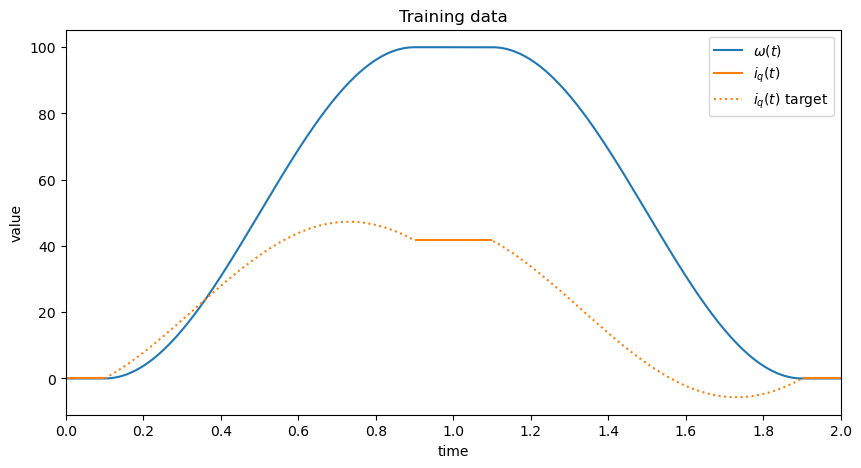

In [3]:
f = plt.figure(figsize=(int(10),int(5)))
plt.title("Training data")
plt.xlabel("time")
plt.ylabel("value")
plt.xlim(START, END)
plt.xticks(torch.arange(START, END+float(0.2), float(0.2)))
lines = plt.plot(train_x, train_y)
target_line = plt.plot(train_x, iq_target)
target_line[0].set_color(lines[1].get_color())
target_line[0].set_linestyle(":")
plt.legend(["$\\omega(t)$", "$i_q(t)$", "$i_q(t)$ target"])
plt.show()

In [4]:
from linear_operator.operators import DiagLinearOperator  # or DiagLazyTensor if needed

class NoiseStrategy:
    def get_noise(self, *, noise, task_noises, noise_matrix, mask, train_x, test_x):
        raise NotImplementedError

class ManualNoiseStrategy(NoiseStrategy):
    def __init__(self, manual_noise_values):
        self.manual_noise_values = manual_noise_values  # Shape: (N_train, num_tasks)

    def get_noise(self, *, noise, task_noises, noise_matrix, mask, train_x, test_x, num_tasks):
        """
        Blend manual and learned noise using the mask
        """
        if (train_x.shape == test_x.shape) and torch.allclose(train_x, test_x):
            # TRAINING MODE → apply full mask-based manual noise
            learned_diag = noise_matrix.diagonal()
            full_mask = mask.flatten()
            manual_noise_flat = self.manual_noise_values.flatten()

            # TODO: MaskedLinearOperator?
            combined_noise_diag = torch.where(full_mask, manual_noise_flat, learned_diag)
            return DiagLinearOperator(combined_noise_diag)
        else:
            # PREDICTION MODE → apply manual noise only to test points overlapping with training points
            matches = torch.isclose(test_x.unsqueeze(int(1)), train_x.unsqueeze(int(0)))  # [N_test, N_train]
            matched_indices = matches.any(dim=int(1))

            # Default to learned noise
            learned_diag = noise_matrix.diagonal()
            combined_diag = learned_diag.clone()

            # If a test point matches a training point, substitute its noise with manual
            for i in range(test_x.size(int(0))):
                if matched_indices[i]:
                    match_idx = matches[i].nonzero(as_tuple=False)[int(0)].item()  # Use first match
                    manual = self.manual_noise_values[match_idx]
                    combined_diag[i * num_tasks : (i+int(1))*num_tasks] = manual

            return DiagLinearOperator(combined_diag)



class ManualNoiseLikelihood(gpytorch.likelihoods.MultitaskGaussianLikelihood):
    def __init__(self, *args, **kwargs):
        _kwargs = kwargs
        self.noise_strategy = _kwargs.pop("noise_strategy", None)
        super().__init__(*args, **_kwargs)

    def set_noise_strategy(self, noise_strategy: NoiseStrategy):
        self.noise_strategy = noise_strategy

    def marginal(self, function_dist, *params, **kwargs):
        mean = function_dist.mean
        covar = function_dist.lazy_covariance_matrix

        if not hasattr(self, "noise_strategy"):
            return super().marginal(function_dist, *params, **kwargs)

        mask = kwargs.get("mask", None)
        train_x = kwargs.get("train_data", None)
        test_x = kwargs.get("current_data", None)

        # If any of these are missing, we assume this is the internal call from prediction strategy setup
        # Use default behavior: add only learned noise
        if mask is None or train_x is None or test_x is None:
            # Infer shape safely
            num_data = function_dist.mean.numel() // self.num_tasks
            original_shape = (num_data, self.num_tasks)
            result_covar = function_dist.lazy_covariance_matrix + super()._shaped_noise_covar(original_shape, add_noise=self.has_global_noise)
            return function_dist.__class__(function_dist.mean, result_covar)


        # Base learned noise matrix
        # Infer the shape from the function distribution's mean
        num_data = function_dist.mean.numel() // self.num_tasks
        base_noise_matrix = self._shaped_noise_covar((num_data, self.num_tasks), add_noise=self.has_global_noise)

        num_tasks = self.num_tasks

        new_noise = self.noise_strategy.get_noise(
            noise=self.noise,
            task_noises=self.task_noises,
            noise_matrix=base_noise_matrix,
            mask=mask,
            train_x=train_x,
            test_x=test_x,
            num_tasks=num_tasks
        )

        result_covar = covar + new_noise
        return function_dist.__class__(mean, result_covar)

In [5]:
print("Training with GPyTorch noise")
# model definition
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=int(2))

model = LODEGP(
    train_x, train_y, likelihood, int(2),
    ODE_name="PMSM",
    system_parameters=sp,
    base_kernel="SE_kernel"
)
model.train()
likelihood.train()
optimizer = torch.optim.Adam(model.parameters(), lr=float(0.01))
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

with gpytorch.settings.observation_nan_policy("mask"), linear_operator.settings.max_cholesky_size(1), gpytorch.settings.max_preconditioner_size(0):
    start_time = perf_counter()
    for i in range(TRAIN_ITERATIONS):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        #loss = -mll(output, train_y, train_data=train_x, current_data=train_x, mask=manual_noise_mask)
        loss.backward()
        optimizer.step()
    print(f"Training time: {perf_counter() - start_time:.2f}s")

# model definition
likelihood_approx = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=int(2))
model_approx = LODEGP(
    train_x, train_y, likelihood_approx, int(2),
    ODE_name="PMSM",
    system_parameters=sp,
    approx=True,
    number_of_eigenvalues=int(50),
    base_kernel="SE_kernel"
)
model_approx.train()
likelihood_approx.train()
optimizer_approx = torch.optim.Adam(model_approx.parameters(), lr=float(0.01))
mll_approx = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_approx, model_approx)

with gpytorch.settings.observation_nan_policy("mask"), linear_operator.settings.max_cholesky_size(1), gpytorch.settings.max_preconditioner_size(0):
    start_time = perf_counter()
    for i in range(TRAIN_ITERATIONS):
        optimizer_approx.zero_grad()
        output = model_approx(train_x)
        loss = -mll_approx(output, train_y)
        loss.backward()
        optimizer_approx.step()
    print(f"Training time Approx: {perf_counter() - start_time:.2f}s")

to_plot = dict()

model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.observation_nan_policy("mask"):
    start_time = perf_counter()
    test_x = torch.linspace(START, END, COUNT//int(2))
    predictions = likelihood(model(test_x))
    #predictions = likelihood(model(test_x), train_data=train_x, current_data=test_x, mask=manual_noise_mask)
    mean = predictions.mean
    # compute confidence region
    # we want to use lazily evaluated kernel and cannot call forward(..., diag=True)
    var = predictions.covariance_matrix.diagonal().view(mean.size())
    lower = mean - float(2) * var.sqrt()
    upper = mean + float(2) * var.sqrt()
    print(f"Eval time: {perf_counter() - start_time:.2f}s")
    to_plot["mean"] = mean
    to_plot["lower"] = lower
    to_plot["upper"] = upper

model_approx.eval()
likelihood_approx.eval()
with torch.no_grad(), gpytorch.settings.observation_nan_policy("mask"), linear_operator.settings.max_cholesky_size(1), gpytorch.settings.max_preconditioner_size(0):
    start_time = perf_counter()
    test_x = torch.linspace(START, END, COUNT//int(2))
    predictions = likelihood_approx(model_approx(test_x))
    mean = predictions.mean
    # compute confidence region
    # (we want to use lazily evaluated kernel and cannot call forward(..., diag=True)
    var = predictions.covariance_matrix.diagonal().view(mean.size())
    lower = mean - float(2) * var.sqrt()
    upper = mean + float(2) * var.sqrt()
    print(f"Eval time Approximate: {perf_counter() - start_time:.2f}s")
    to_plot["mean_approx"] = mean
    to_plot["lower_approx"] = lower
    to_plot["upper_approx"] = upper

Training with GPyTorch noise
Training time: 8.58s
Training time Approx: 9.28s
Eval time: 0.07s
Eval time Approximate: 0.89s


In [6]:
print("Training with manual noise")
# model definition
manual_noise_values = torch.full_like(train_y, float(1e-9))
manual_noise_strat = ManualNoiseStrategy(manual_noise_values)
likelihood = ManualNoiseLikelihood(num_tasks=int(2), noise_strategy=manual_noise_strat)
manual_noise_mask = torch.full_like(train_y, False, dtype=torch.bool)
manual_noise_mask[int(0), int(0)] = True
manual_noise_mask[int(-1), int(0)] = True
manual_noise_mask = torch.where(torch.isnan(train_y), False, True)

model = LODEGP(
    train_x, train_y, likelihood, int(2),
    ODE_name="PMSM",
    system_parameters=sp,
    base_kernel="SE_kernel"
)
model.train()
likelihood.train()
optimizer = torch.optim.Adam(model.parameters(), lr=float(0.01))
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

with gpytorch.settings.observation_nan_policy("mask"), linear_operator.settings.max_cholesky_size(1), gpytorch.settings.max_preconditioner_size(0):
    start_time = perf_counter()
    for i in range(TRAIN_ITERATIONS):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y, train_data=train_x, current_data=train_x, mask=manual_noise_mask)
        loss.backward()
        optimizer.step()
    print(f"Training time: {perf_counter() - start_time:.2f}s")

# model definition
likelihood_approx = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=int(2))
model_approx = LODEGP(
    train_x, train_y, likelihood_approx, int(2),
    ODE_name="PMSM",
    system_parameters=sp,
    approx=True,
    number_of_eigenvalues=int(50),
    base_kernel="SE_kernel"
)
model_approx.train()
likelihood_approx.train()
optimizer_approx = torch.optim.Adam(model_approx.parameters(), lr=float(0.01))
mll_approx = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_approx, model_approx)

with gpytorch.settings.observation_nan_policy("mask"), linear_operator.settings.max_cholesky_size(1), gpytorch.settings.max_preconditioner_size(0):
    start_time = perf_counter()
    for i in range(TRAIN_ITERATIONS):
        optimizer_approx.zero_grad()
        output = model_approx(train_x)
        loss = -mll(output, train_y, train_data=train_x, current_data=train_x, mask=manual_noise_mask)
        loss.backward()
        optimizer_approx.step()
    print(f"Training time Approx: {perf_counter() - start_time:.2f}s")

model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.observation_nan_policy("mask"):
    start_time = perf_counter()
    test_x = torch.linspace(START, END, COUNT//int(2))
    predictions = likelihood(model(test_x), train_data=train_x, current_data=test_x, mask=manual_noise_mask)
    mean = predictions.mean
    # compute confidence region
    # we want to use lazily evaluated kernel and cannot call forward(..., diag=True)
    var = predictions.covariance_matrix.diagonal().view(mean.size())
    lower = mean - float(2) * var.sqrt()
    upper = mean + float(2) * var.sqrt()
    print(f"Eval time: {perf_counter() - start_time:.2f}s")
    to_plot["mean_manual"] = mean
    to_plot["lower_manual"] = lower
    to_plot["upper_manual"] = upper

model_approx.eval()
likelihood_approx.eval()
with torch.no_grad(), gpytorch.settings.observation_nan_policy("mask"), linear_operator.settings.max_cholesky_size(1), gpytorch.settings.max_preconditioner_size(0):
    start_time = perf_counter()
    test_x = torch.linspace(START, END, COUNT//int(2))
    predictions = likelihood(model(test_x), train_data=train_x, current_data=test_x, mask=manual_noise_mask)
    mean = predictions.mean
    # compute confidence region
    # (we want to use lazily evaluated kernel and cannot call forward(..., diag=True)
    var = predictions.covariance_matrix.diagonal().view(mean.size())
    lower = mean - float(2) * var.sqrt()
    upper = mean + float(2) * var.sqrt()
    print(f"Eval time Approximate: {perf_counter() - start_time:.2f}s")
    to_plot["mean_approx_manual"] = mean
    to_plot["lower_approx_manual"] = lower
    to_plot["upper_approx_manual"] = upper

Training with manual noise
Training time: 147.53s
Training time Approx: 90.85s
Eval time: 0.07s
Eval time Approximate: 1.46s


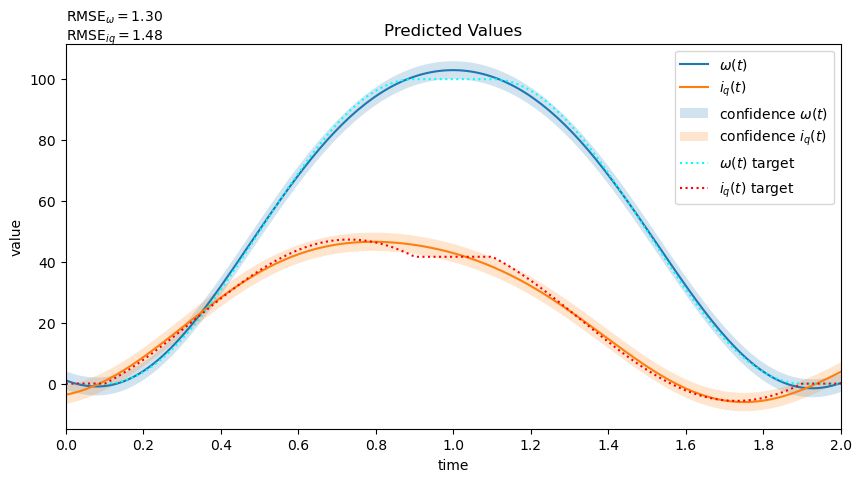

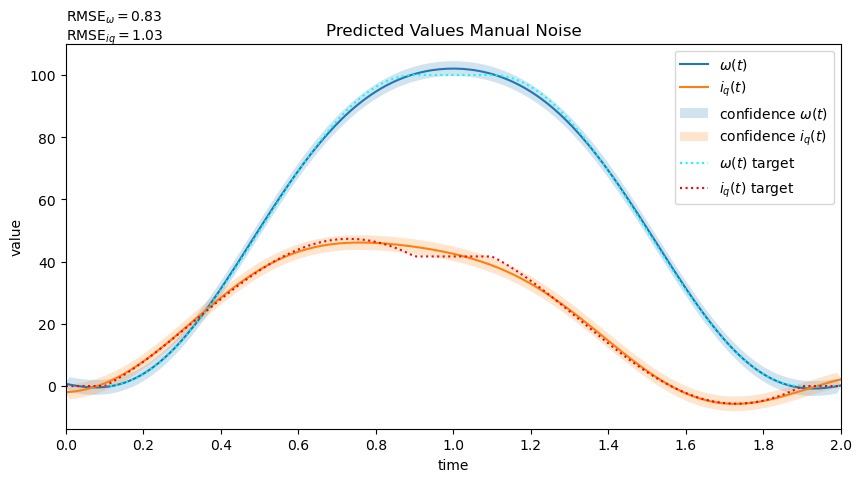

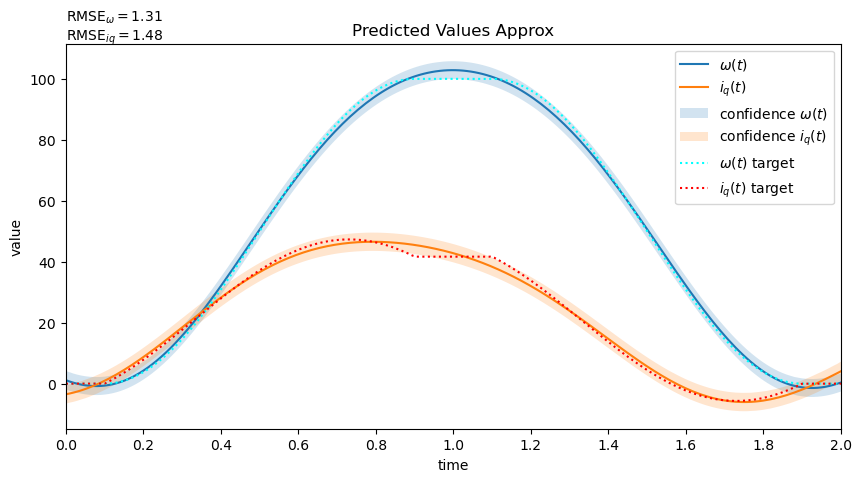

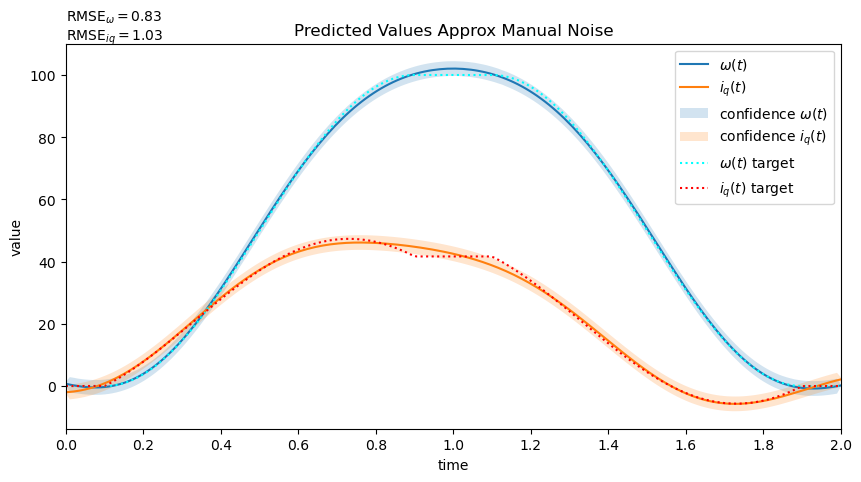

In [7]:
import numpy as np
def plot(m, low, up, title, annotation=None):
    f = plt.figure(figsize=(int(10),int(5)))
    plt.title(title)
    plt.xlabel("time")
    plt.ylabel("value")
    plt.xlim(START, END)
    test_y = torch.stack([m[:, 0], m[:, 1]], dim=int(-1))
    plt.plot(test_x, test_y)
    plt.fill_between(test_x, low[:, 0], up[:, 0], alpha=0.2)
    plt.fill_between(test_x, low[:, 1], up[:, 1], alpha=0.2)
    target_line = plt.plot(test_x, omega)
    target_line[0].set_color("cyan")
    target_line[0].set_linestyle(":")
    target_line = plt.plot(test_x, iq_target)
    target_line[0].set_color("red")
    target_line[0].set_linestyle(":")
    plt.xticks(torch.arange(START, END+float(0.2), float(0.2)))
    plt.annotate(text=annotation, xy=(0, 1.01), xycoords='axes fraction')
    plt.legend(["$\\omega(t)$", "$i_q(t)$", "confidence $\\omega(t)$", "confidence $i_q(t)$", "$\\omega(t)$ target", "$i_q(t)$ target"])
    
# create targets in test sizes
steps_s = (COUNT//int(2)) / END
cosine_interp = lambda x, y0, y1, a, b: y0 + (y1 - y0) * (float(1) - torch.cos(pi * (x-a)/(b-a))) / float(2)
omega = torch.zeros_like(test_x)
ramp = cosine_interp(test_x, float(0), float(100), float(0.1), float(0.9))
omega[int(0.1 * steps_s): int(0.9 * steps_s)] = ramp[int(0.1 * steps_s): int(0.9 * steps_s)]
omega[int(0.9 * steps_s): int(1.1 * steps_s)] = torch.full([int(0.2 * steps_s)], float(100))
ramp = cosine_interp(test_x, float(100), float(0), float(1.1), float(1.9))
omega[int(1.1 * steps_s): int(1.9 * steps_s)] = ramp[int(1.1 * steps_s): int(1.9 * steps_s)]

iq = torch.full([COUNT//int(2)], torch.nan)
bm_c = sp["bm"] / (float(3)/float(4) * sp["p"] * sp["Phi"])
iq[:int(0.1 * steps_s)] = torch.zeros(int(0.1 * steps_s))
iq[int(0.9 * steps_s):int(1.1 * steps_s)] = torch.full([int(0.2 * steps_s)], bm_c * float(100))
iq[int(1.9 * steps_s):] = torch.zeros(int(0.1 * steps_s))

d_cos = lambda x, y0, y1, a, b: pi*(y1-y0)*torch.sin(pi*(x-a)/(b-a)) / (2*(b-a))
J_c = sp["Jm"] / (float(3)/float(4) * sp["p"] * sp["Phi"])
iq_target = torch.full([COUNT//int(2)], torch.nan)
d_omega = d_cos(test_x, float(0), float(100), float(0.1), float(0.9))
ramp_up = J_c * d_omega + bm_c * omega
iq_target[int(0.1 * steps_s): int(0.9 * steps_s)] = ramp_up[int(0.1 * steps_s): int(0.9 * steps_s)]
d_omega = d_cos(test_x, float(100), float(0), float(1.1), float(1.9))
ramp_up = J_c * d_omega + bm_c * omega
iq_target[int(1.1 * steps_s): int(1.9 * steps_s)] = ramp_up[int(1.1 * steps_s): int(1.9 * steps_s)]
iq_target = iq_target.nan_to_num(float(0)) + iq.nan_to_num(float(0))

rmse_omega = torch.sqrt(torch.mean((to_plot["mean"][:, 0] - omega) ** int(2)))
rmse_iq = torch.sqrt(torch.mean((to_plot["mean"][:, 1] - iq_target) ** int(2)))
annotation = r"RMSE$_{\omega}" + f"={rmse_omega:.2f}$\n" + r"RMSE$_{iq}" + f"={rmse_iq:.2f}$"
plot(to_plot["mean"], to_plot["lower"], to_plot["upper"], "Predicted Values", annotation)

rmse_omega = torch.sqrt(torch.mean((to_plot["mean_manual"][:, 0] - omega) ** int(2)))
rmse_iq = torch.sqrt(torch.mean((to_plot["mean_manual"][:, 1] - iq_target) ** int(2)))
annotation = r"RMSE$_{\omega}" + f"={rmse_omega:.2f}$\n" + r"RMSE$_{iq}" + f"={rmse_iq:.2f}$"
plot(to_plot["mean_manual"], to_plot["lower_manual"], to_plot["upper_manual"], "Predicted Values Manual Noise", annotation)

rmse_omega = torch.sqrt(torch.mean((to_plot["mean_approx"][:, 0] - omega) ** int(2)))
rmse_iq = torch.sqrt(torch.mean((to_plot["mean_approx"][:, 1] - iq_target) ** int(2)))
annotation = r"RMSE$_{\omega}" + f"={rmse_omega:.2f}$\n" + r"RMSE$_{iq}" + f"={rmse_iq:.2f}$"
plot(to_plot["mean_approx"], to_plot["lower_approx"], to_plot["upper_approx"], "Predicted Values Approx", annotation)

rmse_omega = torch.sqrt(torch.mean((to_plot["mean_approx_manual"][:, 0] - omega) ** int(2)))
rmse_iq = torch.sqrt(torch.mean((to_plot["mean_approx_manual"][:, 1] - iq_target) ** int(2)))
annotation = r"RMSE$_{\omega}" + f"={rmse_omega:.2f}$\n" + r"RMSE$_{iq}" + f"={rmse_iq:.2f}$"
plot(to_plot["mean_approx_manual"], to_plot["lower_approx_manual"], to_plot["upper_approx_manual"], "Predicted Values Approx Manual Noise", annotation)